# Scale 분석

압연공정에서의 scale불량의 원인을 찾고 개선을 위한 최적의 조건 도출


[분석 기법]

1. 그래프를 활용한 탐색적 분석
2. 로지스틱 회귀분석
3. 의사결정 트리
4. 앙상블 모델(Random Forest, Gradient Boosting)
5. KNN

#### 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz

# 분석
import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# confusion matrix, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score

#### pandas 소수점 3자리

In [2]:
pd.options.display.precision = 3

#### 한글 폰트 적용

In [3]:
# 한글 폰트(맑은 고딕) 적용
matplotlib.rc("font", family="Malgun Gothic")

## 데이터 불러오기

In [4]:
df_raw = pd.read_csv("D:/WORK/DATA/SCALE불량.csv", engine="python")
print("shape: ", df_raw.shape)
df_raw.head()

shape:  (720, 21)


,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


## EDA

#### 기초통계량

In [5]:
df_raw.describe()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
count,720.000,720.000,720.000,720.000,720.000,720.000,720.000,720.000,720.000,720.000,720.000,720.000,720.000
mean,29.268,2807.128,34323.269,41481.778,1.497,1155.339,88.528,1149.667,78.803,300.564,1149.667,933.921,8.319
std,19.153,517.840,13828.435,24751.322,0.500,20.866,37.661,17.572,36.421,45.390,17.572,107.864,1.623
min,12.030,1800.000,7893.000,7820.000,1.000,1103.000,43.000,1113.000,35.000,221.000,1113.000,0.000,5.000
25%,16.090,2466.000,22663.000,17757.500,1.000,1139.000,65.000,1132.000,57.750,257.000,1132.000,889.750,6.000
50%,20.130,2725.000,37380.000,36120.000,1.000,1158.000,75.000,1155.000,67.500,304.000,1155.000,951.000,8.000
75%,40.000,3125.000,43735.000,61120.000,2.000,1171.000,101.000,1164.000,86.000,342.000,1164.000,994.250,10.000
max,100.340,4575.000,54917.000,115080.000,2.000,1206.000,312.000,1185.000,294.000,398.000,1185.000,1078.000,10.000


#### 히스토그램 - 양/불 기준

In [6]:
def fun_plot_hist(data, var):
    plt.hist(data[data["SCALE"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["SCALE"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.legend()

##### plate 두께

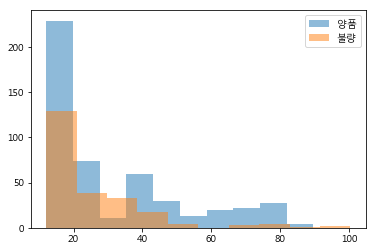

In [7]:
fun_plot_hist(df_raw, "PT_THK")

##### plate 폭

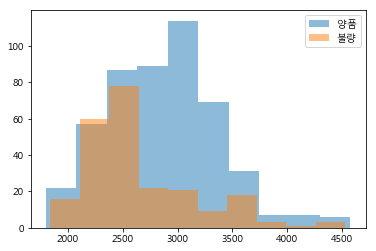

In [8]:
fun_plot_hist(df_raw, "PT_WDTH")

##### plate 길이

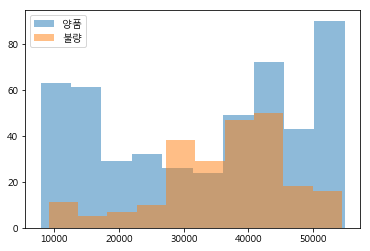

In [9]:
fun_plot_hist(df_raw, "PT_LTH")

##### plate 중량

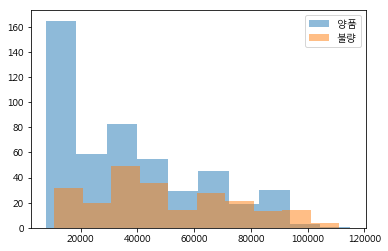

In [10]:
fun_plot_hist(df_raw, "PT_WGT")

##### 가열로 가열대 온도

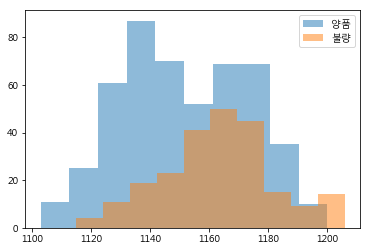

In [11]:
fun_plot_hist(df_raw, "FUR_HZ_TEMP")

##### 가열로 균열대 시간

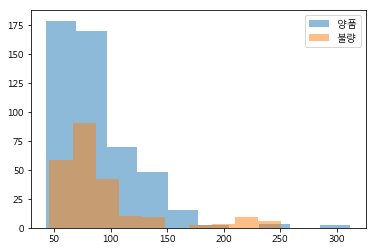

In [12]:
fun_plot_hist(df_raw, "FUR_HZ_TIME")

##### 가열로 균열대 온도

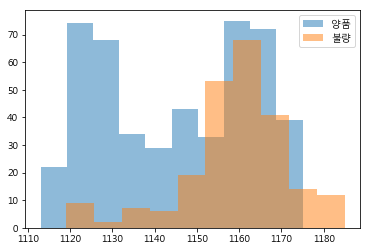

In [13]:
fun_plot_hist(df_raw, "FUR_SZ_TEMP")

##### 가열로 균열대 시간

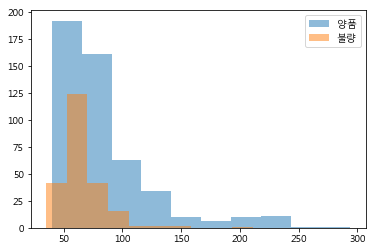

In [14]:
fun_plot_hist(df_raw, "FUR_SZ_TIME")

##### 가열로 시간

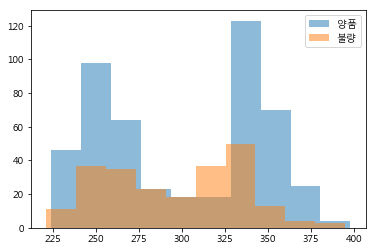

In [15]:
fun_plot_hist(df_raw, "FUR_TIME")

##### 압연 온도

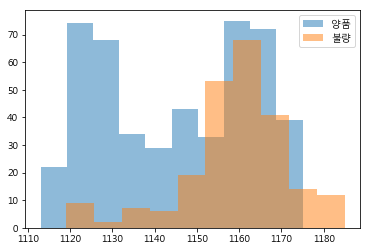

In [16]:
fun_plot_hist(df_raw, "FUR_EXTEMP")

##### 가열대 온도

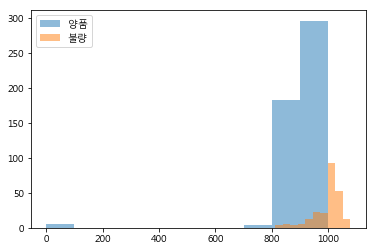

In [17]:
fun_plot_hist(df_raw, "ROLLING_TEMP_T5")

##### 압연 중 Descaling 횟수

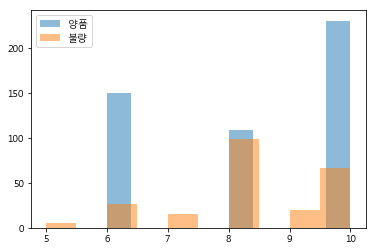

In [18]:
fun_plot_hist(df_raw, "ROLLING_DESCALING")

#### 교차표

In [19]:
def fun_print_crosstab(data, var):
    print(pd.crosstab(index = data["SCALE"], columns = data[var]))
    print()
    print(pd.crosstab(index = data["SCALE"], columns = data[var], normalize = "columns").round(3))

##### 가열로 호기

In [20]:
fun_print_crosstab(df_raw, "FUR_NO")

FUR_NO  1호기  2호기  3호기
SCALE                
불량       73   70   88
양품      167  167  155

FUR_NO    1호기    2호기    3호기
SCALE                      
불량      0.304  0.295  0.362
양품      0.696  0.705  0.638


##### HSB 적용

In [21]:
fun_print_crosstab(df_raw, "HSB")

HSB    미적용   적용
SCALE          
불량      33  198
양품       0  489

HSB    미적용     적용
SCALE            
불량     1.0  0.288
양품     0.0  0.712


##### 작업조

In [22]:
fun_print_crosstab(df_raw, "WORK_GR")

WORK_GR   1조   2조   3조   4조
SCALE                      
불량        67   45   54   65
양품       122  120  118  129

WORK_GR     1조     2조     3조     4조
SCALE                              
불량       0.354  0.273  0.314  0.335
양품       0.646  0.727  0.686  0.665


#### 목표변수 형변환(문자형 -> 숫자형)

In [23]:
df_raw["SCALE"] = np.where(df_raw["SCALE"]== "양품", 0, 1)
df_raw["SCALE"].head()

0    0
1    0
2    0
3    0
4    0
Name: SCALE, dtype: int32

#### 데이터 분할

In [24]:
df_train, df_test = train_test_split(df_raw, test_size = 0.3, random_state = 1234)
print("shape of train data: ", df_train.shape)
print("shape of test data: ", df_test.shape)

shape of train data:  (504, 21)
shape of test data:  (216, 21)


## 로지스틱

In [25]:
model_log = sm.Logit.from_formula("""SCALE ~ PT_THK + PT_WDTH + PT_LTH + PT_WGT + C(FUR_NO) + 
                                  FUR_NO_ROW + FUR_HZ_TEMP + FUR_HZ_TIME + FUR_SZ_TEMP + FUR_SZ_TIME + 
                                  FUR_TIME + FUR_EXTEMP + ROLLING_TEMP_T5 + C(HSB) + ROLLING_DESCALING + C(WORK_GR) + 1""" ,
                                  df_train)

# 적합
model_result = model_log.fit()
# 결과 출력
print(model_result.summary())

         Current function value: 0.258678
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  504
Model:                          Logit   Df Residuals:                      485
Method:                           MLE   Df Model:                           18
Date:                Tue, 30 Apr 2019   Pseudo R-squ.:                  0.5861
Time:                        17:28:22   Log-Likelihood:                -130.37
converged:                      False   LL-Null:                       -314.97
                                        LLR p-value:                 2.368e-67
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -84.6496   6.24e+04     -0.001      0.999   -1.22e+05    1.22e+05
C(FUR_NO)[T.2호기]      0.1144      0.397     

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### 예측 & 평가

In [26]:
# 평가
y_pred = model_result.predict(df_test)
# 0과 1의 값을 가진 class로 변환
y_pred = (y_pred > 0.5).astype(int)

# accuracy_score
print("Accuracy: {:.3f}\n".format(accuracy_score(df_test["SCALE"], y_pred)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test["SCALE"], y_pred)))

Accuracy: 0.861

Confusion matrix: 
[[125  20]
 [ 10  61]]


## 의사결정나무

### 데이터 전처리

#### 변수 역할 지정

In [27]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["SCALE"]
df_raw_x = df_raw.drop("SCALE", axis = 1, inplace = False)

#### 더미변수 생성

In [28]:
df_dummy = pd.get_dummies(df_raw_x.drop(["PLATE_NO", "ROLLING_DATE", "SPEC", "STEEL_KIND"], axis = 1, inplace = False))
print("shape of dummy data:", df_dummy.shape)
df_dummy.head()

shape of dummy data: (720, 22)


,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,...,ROLLING_DESCALING,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,32.25,3707,15109,14180,1,1144,116,1133,59,282,...,8,1,0,0,0,1,0,1,0,0
1,32.25,3707,15109,14180,2,1144,122,1135,53,283,...,8,1,0,0,0,1,0,1,0,0
2,33.27,3619,19181,18130,1,1129,116,1121,55,282,...,8,0,1,0,0,1,0,0,1,0
3,33.27,3619,19181,18130,2,1152,125,1127,68,316,...,8,0,1,0,0,1,0,0,1,0
4,38.33,3098,13334,12430,1,1140,134,1128,48,314,...,8,0,0,1,0,1,1,0,0,0


#### 데이터 분할

In [29]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_dummy, df_raw_y, test_size = 0.3, random_state = 1234)

## 의사결정나무

#### 기본 옵션으로 트리 생성

In [30]:
tree_uncustomized = DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)
# 훈련 데이터 정확도
print("Accucary on train set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accucary on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Accucary on train set: 1.000
Accucary on test set: 0.968


#### max_depth: 최대 깊이 변경에 따른 정확도 변화

In [31]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy
df_accuracy_depth

,Depth,TrainAccuracy,TestAccuracy
0,1,0.887,0.898
1,2,0.929,0.944
2,3,0.958,0.972
3,4,0.966,0.977
4,5,0.968,0.977
5,6,0.972,0.977
6,7,0.972,0.977
7,8,0.976,0.977
8,9,0.982,0.981
9,10,0.982,0.981


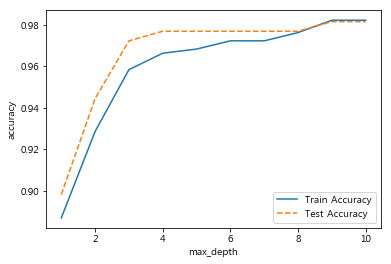

In [32]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max_depth"); plt.ylabel("accuracy")
plt.legend()

max_depth = 4

#### min_samples_leaf: 잎사귀 노드의 샘플 수 제한

In [33]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 10 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_min_samples_leaf, max_depth=4, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
df_accuracy_leaf

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.958,0.972
1,20,0.944,0.963
2,30,0.897,0.903
3,40,0.887,0.898
4,50,0.887,0.898
5,60,0.887,0.898
6,70,0.887,0.898
7,80,0.887,0.898
8,90,0.887,0.898
9,100,0.887,0.898


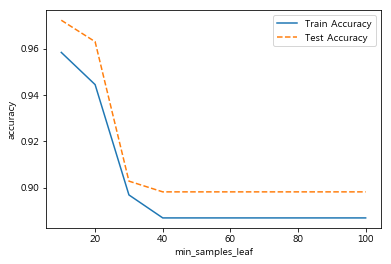

In [34]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_leaf"); plt.ylabel("accuracy")
plt.legend()

min_samples_leaf = 20

#### min_samples_split: 분할하기 위한 노드의 최소 샘플 수

In [35]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수 
para_split = [n_split * 20 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split=v_min_samples_split, min_samples_leaf = 20, max_depth = 4, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
df_accuracy_split

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.944,0.963
1,40,0.944,0.963
2,60,0.944,0.963
3,80,0.944,0.963
4,100,0.944,0.963
5,120,0.944,0.963
6,140,0.944,0.963
7,160,0.944,0.963
8,180,0.944,0.963
9,200,0.944,0.963


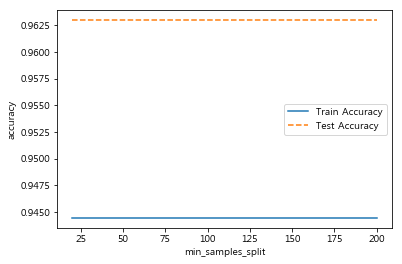

In [36]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_split"); plt.ylabel("accuracy")
plt.legend()

### 최종 모델

In [37]:
tree_final = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 20)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### 예측 & 평가

In [38]:
# 평가
y_pred = tree_final.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy: 0.963

Confusion matrix: 
[[143   2]
 [  6  65]]


### 변수 중요도

In [39]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = df_train_x.columns
df_importance["Importance"] = tree_final.feature_importances_

# ds_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance

,Feature,Importance
11,ROLLING_TEMP_T5,0.704
16,HSB_미적용,0.191
10,FUR_EXTEMP,0.094
12,ROLLING_DESCALING,0.011
20,WORK_GR_3조,0.000
19,WORK_GR_2조,0.000
18,WORK_GR_1조,0.000
17,HSB_적용,0.000
15,FUR_NO_3호기,0.000
14,FUR_NO_2호기,0.000


Text(0,0.5,'설명변수')

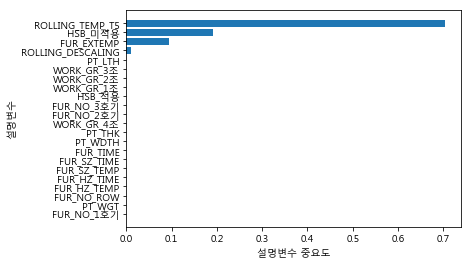

In [40]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## 랜덤포레스트

#### 기본 옵션으로 트리 생성

In [41]:
# 랜덤 포레스트 모델 생성: RandomForestClassifier
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)
# 훈련 데이터 셋 정확도
print("Accuracy on train set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
# 테스트 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Accuracy on train set: 0.992
Accuracy on test set: 0.963


C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### 트리의 개수(n_estimators) 변경 시 모델의 정확도 확인

In [42]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경: 1~16
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators = v_n_estimators, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

# 테이블 결과
df_accuracy_n

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.992,0.963
1,20,0.994,0.968
2,30,1.000,0.972
3,40,1.000,0.972
4,50,1.000,0.972
5,60,1.000,0.972
6,70,1.000,0.972
7,80,1.000,0.972
8,90,1.000,0.972
9,100,1.000,0.972


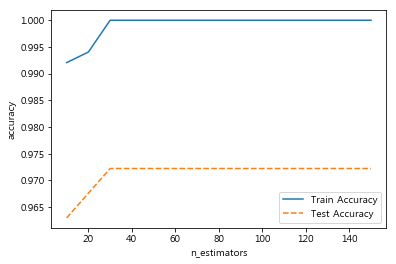

In [43]:
# 정확도를 그래프로 표현
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
plt.legend()

#### 트리의 개수에 따른 oob error 변화

In [44]:
# error 저장 리스트
oob_error = []

for v_n_estimator in range(1, 151):
    rf = RandomForestClassifier(n_estimators = v_n_estimator, oob_score = True, random_state= 1234)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1 - rf.oob_score_)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob esti

Text(0.5,0,'n_estimators')

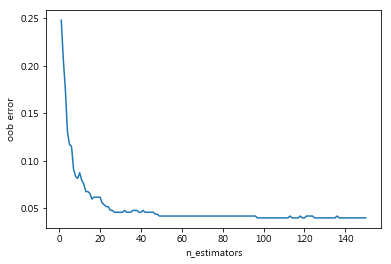

In [45]:
# 그래프로 표현
plt.plot(range(1, 151), oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

#### max_depth: 최대 깊이 변경에 따른 정확도 변화

In [46]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(max_depth = v_max_depth, n_estimators = 100, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

# 테이블 결과
df_accuracy_depth

,Depth,TrainAccuracy,TestAccuracy
0,1,0.855,0.861
1,2,0.903,0.903
2,3,0.954,0.968
3,4,0.960,0.972
4,5,0.960,0.972
5,6,0.962,0.972
6,7,0.972,0.972
7,8,0.988,0.972
8,9,0.996,0.972
9,10,0.996,0.972


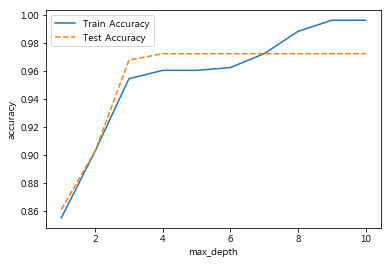

In [47]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max_depth"); plt.ylabel("accuracy")
plt.legend()

max_depth = 3

#### min_samples_leaf: 최소 잎사귀 수 제한

In [48]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 10 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(min_samples_leaf = v_min_samples_leaf,
                                max_depth = 3, n_estimators = 100, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

# 테이블 결과
df_accuracy_leaf

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.925,0.921
1,20,0.883,0.894
2,30,0.877,0.889
3,40,0.873,0.889
4,50,0.873,0.889
5,60,0.873,0.889
6,70,0.863,0.866
7,80,0.849,0.843
8,90,0.817,0.847
9,100,0.780,0.773


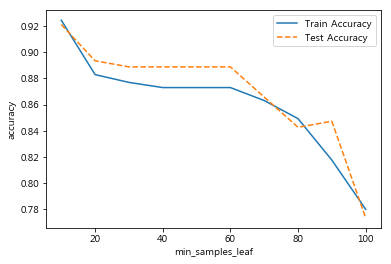

In [49]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_leaf"); plt.ylabel("accuracy")
plt.legend()

min_samples_leaf = 10

#### min_samples_split: 분리 노드의 최소 샘플 수 제한

In [50]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수 
para_split = [n_split * 10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(min_samples_split = v_min_samples_split,
                                min_samples_leaf = 10, max_depth = 3, n_estimators = 100, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

# 테이블 결과
df_accuracy_split

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.925,0.921
1,20,0.925,0.921
2,30,0.927,0.917
3,40,0.927,0.917
4,50,0.927,0.917
5,60,0.927,0.912
6,70,0.927,0.912
7,80,0.923,0.921
8,90,0.921,0.912
9,100,0.915,0.907


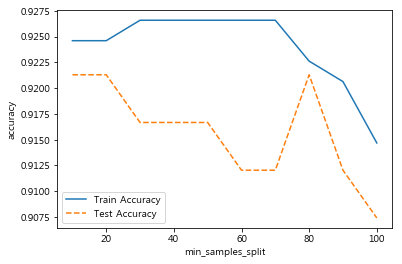

In [51]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min_samples_split"); plt.ylabel("accuracy")
plt.legend()

min_samples_split = 20

### 최종 모델 생성

In [52]:
# 최종 모델
rf_final = RandomForestClassifier(min_samples_leaf = 10, min_samples_split = 20, max_depth = 3, n_estimators = 100, random_state=1234)
rf_final.fit(df_train_x, df_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

#### 예측 & 평가

In [53]:
# 예측
y_pred = rf_final.predict(df_test_x)

# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(rf_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.925
Accuracy on test set: 0.921

Confusion matrix: 
[[145   0]
 [ 17  54]]


### 설명변수의 중요도

In [56]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = df_train_x.columns
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance

,Feature,Importance
11,ROLLING_TEMP_T5,3.452e-01
10,FUR_EXTEMP,1.243e-01
7,FUR_SZ_TEMP,1.228e-01
0,PT_THK,6.457e-02
1,PT_WDTH,5.772e-02
2,PT_LTH,5.105e-02
12,ROLLING_DESCALING,3.992e-02
3,PT_WGT,3.953e-02
8,FUR_SZ_TIME,3.537e-02
5,FUR_HZ_TEMP,3.409e-02


Text(0,0.5,'변수')

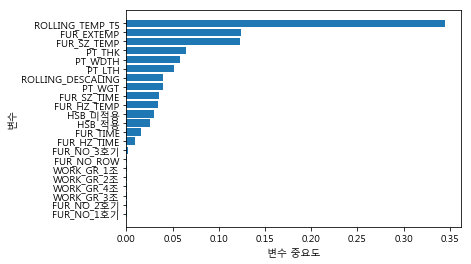

In [57]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

## 그래디언트 부스팅

기본 옵션으로 트리 생성

In [58]:
# 그래디언트 부스팅 모델 생성: GradientBoostingClassifier
gb_uncustomized = GradientBoostingClassifier(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("Accuracy on train set: {:.3f}".format(gb_uncustomized.score (df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(gb_uncustomized.score (df_test_x, df_test_y)))

Accuracy on train set: 1.000
Accuracy on test set: 1.000


#### n_estimators: 트리의 개수 변경에 따른 모델의 정확도 확인

In [60]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경: 10~150
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators = v_n_estimators, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

# n_estimators별 정확도 테이블
df_accuracy_n

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.958,0.972
1,20,0.966,0.977
2,30,0.974,0.977
3,40,0.988,0.986
4,50,0.996,0.986
5,60,1.000,0.995
6,70,1.000,0.995
7,80,1.000,1.000
8,90,1.000,1.000
9,100,1.000,1.000


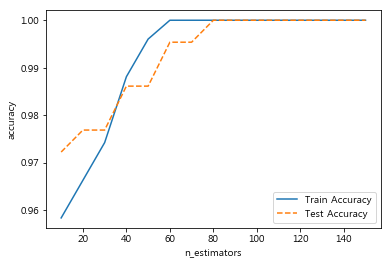

In [61]:
# 정확도를 그래프로 표현
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()

#### learning_rate : 학습률 변경

In [62]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# learning_rate 학습률 변경: 0.1 ~ 0.9
para_lr = [lr * 0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate, n_estimators = 100, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

# LearningRate별 정확도 테이블
df_accuracy_lr

,LearningRate,TrainAccuracy,TestAccuracy
0,0.1,1.0,1.000
1,0.2,1.0,1.000
2,0.3,1.0,1.000
3,0.4,1.0,1.000
4,0.5,1.0,1.000
5,0.6,1.0,0.986
6,0.7,1.0,0.991
7,0.8,1.0,0.981
8,0.9,1.0,0.981


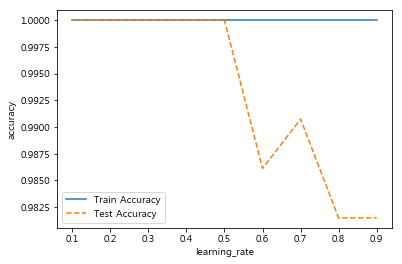

In [64]:
# LearningRate별 정확도 그래프로 확인
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning_rate")
plt.legend()

learning_rate = 0.1

#### max_depth: 최대 깊이 변경에 따른 모델의 정확도 확인

In [65]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = v_max_depth,
                                    n_estimators = 100, learning_rate = 0.1, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

# max_depth별 정확도 테이블
df_accuracy_depth

,Depth,TrainAccuracy,TestAccuracy
0,1,0.966,0.977
1,2,0.994,0.995
2,3,1.000,1.000
3,4,1.000,1.000
4,5,1.000,0.995
5,6,1.000,0.995
6,7,1.000,0.995
7,8,1.000,0.991
8,9,1.000,0.977
9,10,1.000,0.995


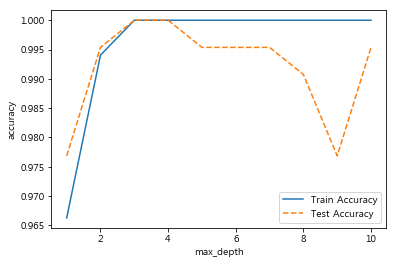

In [67]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("max_depth")
plt.legend()

max_depth = 4

#### min_samples_leaf: leaf 수 변경에 따른 모델의 정확도 확인

In [68]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 10 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf,
                                     max_depth = 4, n_estimators = 100, learning_rate = 0.1, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

# min_samples_leaf별 정확도 테이블
df_accuracy_leaf

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,1.000,0.995
1,20,1.000,0.991
2,30,0.986,0.931
3,40,0.972,0.935
4,50,0.966,0.944
5,60,0.962,0.935
6,70,0.956,0.935
7,80,0.948,0.917
8,90,0.946,0.935
9,100,0.940,0.931


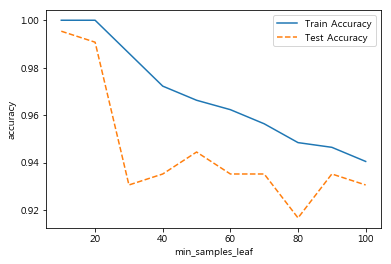

In [70]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min_samples_leaf")
plt.legend()

min_samples_leaf = 10

#### min_samples_split: 분리 노드의 최소 샘플 수에 따른 모델의 정확도 결과

In [71]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수 
para_split = [n_split * 10 for n_split in range(2, 11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split = v_min_samples_split, min_samples_leaf = 10,
                                    max_depth = 4,n_estimators = 100, learning_rate = 0.1, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

# min_samples_leaf별 정확도 테이블
df_accuracy_split

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,1.0,0.995
1,30,1.0,0.995
2,40,1.0,0.995
3,50,1.0,0.995
4,60,1.0,0.991
5,70,1.0,0.991
6,80,1.0,0.991
7,90,1.0,0.991
8,100,1.0,0.991


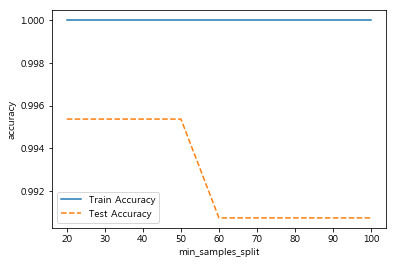

In [73]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min_samples_split")
plt.legend()

min_samples_split = 20

### 최종 모델 선택

In [74]:
# 최종 모델
gb_final = GradientBoostingClassifier(min_samples_leaf = 10, min_samples_split = 20, max_depth = 4, n_estimators = 100,
                                      learning_rate = 0.1, random_state=1234)
gb_final.fit(df_train_x, df_train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=20,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1234,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

### 예측 & 평가

In [75]:
# 예측
y_pred = gb_final.predict(df_test_x)

# train 데이터 셋 정확도
print("Accuracy on train set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on train set: 1.000
Accuracy on test set: 0.995

Confusion matrix: 
[[145   0]
 [  1  70]]


### 목표변수 중요도

In [76]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = df_train_x.columns
df_importance["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance

,Feature,Importance
11,ROLLING_TEMP_T5,6.008e-01
16,HSB_미적용,1.164e-01
7,FUR_SZ_TEMP,8.016e-02
12,ROLLING_DESCALING,5.240e-02
10,FUR_EXTEMP,4.461e-02
0,PT_THK,4.311e-02
17,HSB_적용,4.159e-02
8,FUR_SZ_TIME,5.159e-03
9,FUR_TIME,3.607e-03
2,PT_LTH,2.836e-03


Text(0,0.5,'변수')

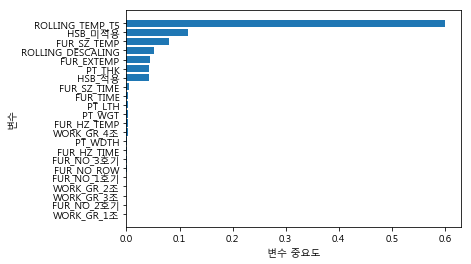

In [78]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림 
df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

## 최근접 이웃

#### 기본 옵션으로 트리 생성

In [79]:
# KNN 모델 생성(default 설정)
knn_uncusotomized = KNeighborsClassifier()
knn_uncusotomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("Accuracy on train set: {:.3f}".format(knn_uncusotomized.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(knn_uncusotomized.score(df_test_x, df_test_y)))

Accuracy on train set: 0.788
Accuracy on test set: 0.764


#### 이웃 수 증가에 따른 정확도 변화

In [80]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# 최대 이웃 수: 1~15
para_n_neighbors = [i for i in range(1, 16)]

for v_n_neighbors in para_n_neighbors:
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_neighbors = pd.DataFrame()
df_accuracy_neighbors["Neighbors"] = para_n_neighbors
df_accuracy_neighbors["TrainAccuracy"] = train_accuracy
df_accuracy_neighbors["TestAccuracy"] = test_accuracy
df_accuracy_neighbors

,Neighbors,TrainAccuracy,TestAccuracy
0,1,1.000,0.722
1,2,0.865,0.755
2,3,0.827,0.759
3,4,0.788,0.755
4,5,0.788,0.764
5,6,0.786,0.736
6,7,0.784,0.755
7,8,0.766,0.731
8,9,0.782,0.764
9,10,0.764,0.731


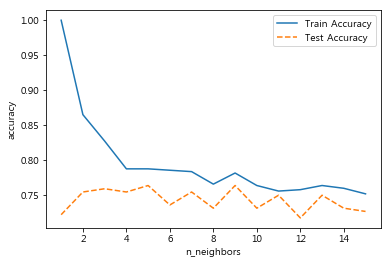

In [81]:
# 정확도를 그래프로 표현
plt.plot(para_n_neighbors, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_neighbors, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_neighbors")
plt.legend()

In [82]:
n_neighbors = 5

#### 가중치별 이웃 수 증가에 따른 설명력 변화

In [84]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# 이웃 수
para_n_neighbors = [i for i in range(1,11)] * 2
# 가중치(uniform, distance)
para_weights = (["uniform"]) * 10 + (["distance"] * 10)

for (v_n_neighbors, v_weights) in zip(para_n_neighbors, para_weights):
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors, weights = v_weights)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))    
    
# 데이터 테이블로 저장
df_accuracy_weights = pd.DataFrame()
df_accuracy_weights["Neighbors"] = para_n_neighbors
df_accuracy_weights["Weights"] = para_weights
df_accuracy_weights["TrainAccuracy"] = train_accuracy
df_accuracy_weights["TestAccuracy"] = test_accuracy

df_accuracy_weights_pivot = df_accuracy_weights.pivot(index = "Neighbors", columns = "Weights", values = ["TrainAccuracy", "TestAccuracy"])

# pivot을 이용할 경우, columns와 values이 2개의 level로 이루어지므로 하나의 level로 변환
level0 = df_accuracy_weights_pivot.columns.get_level_values(0)
level1 = df_accuracy_weights_pivot.columns.get_level_values(1)
df_accuracy_weights_pivot.columns = level0 + "_" + level1
df_accuracy_weights_pivot

,TrainAccuracy_distance,TrainAccuracy_uniform,TestAccuracy_distance,TestAccuracy_uniform
Neighbors,,,,
1,1.0,1.000,0.722,0.722
2,1.0,0.865,0.722,0.755
3,1.0,0.827,0.755,0.759
4,1.0,0.788,0.759,0.755
5,1.0,0.788,0.759,0.764
6,1.0,0.786,0.769,0.736
7,1.0,0.784,0.750,0.755
8,1.0,0.766,0.745,0.731
9,1.0,0.782,0.745,0.764


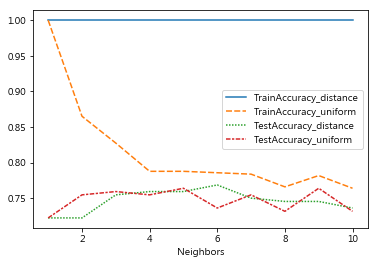

In [86]:
sns.lineplot(data = df_accuracy_weights_pivot)

weights = uniform

#### 거리 계산 방법별 이웃 수 증가에 따른 설명력 변화

In [88]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# 이웃 수
para_n_neighbors = [i for i in range(1,11)] * 3
# 거리 계산 방법 (minkowski, euclidean, manhattan)
para_metric = ["minkowski"] * 10 + ["euclidean"] * 10 + ["manhattan"] * 10

for (v_n_neighbors, v_metric) in zip(para_n_neighbors, para_metric):
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors, metric = v_metric, weights = "uniform")
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))    

# 데이터 테이블로 저장
df_accuracy_metric = pd.DataFrame()
df_accuracy_metric["Neighbors"] = para_n_neighbors
df_accuracy_metric["Metric"] = para_metric
df_accuracy_metric["TrainAccuracy"] = train_accuracy
df_accuracy_metric["TestAccuracy"] = test_accuracy

df_accuracy_metric_pivot = df_accuracy_metric.pivot(index = "Neighbors", columns = "Metric", values = ["TrainAccuracy", "TestAccuracy"])

# pivot을 이용할 경우, columns와 values이 2개의 level로 이루어지므로 하나의 level로 변환
level0 = df_accuracy_metric_pivot.columns.get_level_values(0)
level1 = df_accuracy_metric_pivot.columns.get_level_values(1)
df_accuracy_metric_pivot.columns = level0 + "_" + level1
df_accuracy_metric_pivot

,TrainAccuracy_euclidean,TrainAccuracy_manhattan,TrainAccuracy_minkowski,TestAccuracy_euclidean,TestAccuracy_manhattan,TestAccuracy_minkowski
Neighbors,,,,,,
1,1.000,1.000,1.000,0.722,0.722,0.722
2,0.865,0.869,0.865,0.755,0.750,0.755
3,0.827,0.849,0.827,0.759,0.764,0.759
4,0.788,0.806,0.788,0.755,0.773,0.755
5,0.788,0.810,0.788,0.764,0.787,0.764
6,0.786,0.778,0.786,0.736,0.769,0.736
7,0.784,0.800,0.784,0.755,0.773,0.755
8,0.766,0.782,0.766,0.731,0.750,0.731
9,0.782,0.780,0.782,0.764,0.782,0.764


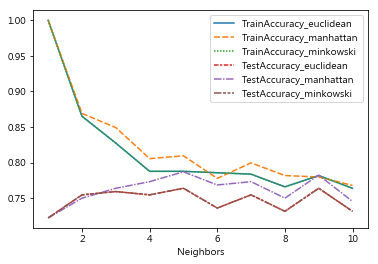

In [90]:
sns.lineplot(data = df_accuracy_metric_pivot)

metric = "manhattan"

### 최종 모델

In [92]:
knn_final = KNeighborsClassifier(n_neighbors = 5, weights = "uniform", metric = "manhattan")
knn_final.fit(df_train_x, df_train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

### 예측 & 평가

In [94]:
# 예측
y_pred = knn_final.predict(df_test_x)

# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(knn_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on test set: 0.787

Confusion matrix: 
[[133  12]
 [ 34  37]]
